# Imports

In [1]:
import os
from pyspark.sql import SparkSession


In [2]:
# set active run directory
path = "/home/ubuntu/veri_analizi"
os.chdir(path)

#create spark session
spark = SparkSession.builder.appName("APRON-VA").getOrCreate()
spark


# SPARK UI: 10.8.131.209 (rabia):4040


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/08 11:00:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
%pwd


'/home/ubuntu/veri_analizi'

# Datasets

## Weather

In [6]:
data_path = path + "/datasources/weather_data.csv"

df_weather = spark.read.csv(data_path, header=True, inferSchema=True)
df_weather.printSchema()


root
 |-- datetime_local: string (nullable = true)
 |-- temperature: integer (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- dew_point: double (nullable = true)
 |-- wind_bearing: integer (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- wind_gust: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- uv_index: integer (nullable = true)
 |-- ozone: double (nullable = true)
 |-- precip_intensity: double (nullable = true)
 |-- icon: string (nullable = true)


In [6]:
df_weather.show()

+----------------+-----------+--------+---------+------------+----------+---------+--------+--------+-----+----------------+-------------------+
|  datetime_local|temperature|humidity|dew_point|wind_bearing|wind_speed|wind_gust|pressure|uv_index|ozone|precip_intensity|               icon|
+----------------+-----------+--------+---------+------------+----------+---------+--------+--------+-----+----------------+-------------------+
|01-10-2019 00:00|         26|       1|    22.01|         101|      3.08|     6.42| 1008.45|       0|268.6|             0.0|partly-cloudy-night|
|01-10-2019 01:00|         25|       1|    22.06|         105|      2.94|     6.28| 1008.24|       0|269.1|             0.0|partly-cloudy-night|
|01-10-2019 02:00|         25|       1|    22.06|         106|      2.82|     6.08|  1007.9|       0|269.7|             0.0|partly-cloudy-night|
|01-10-2019 03:00|         24|       1|    21.87|         106|      2.63|     5.74| 1007.61|       0|270.4|             0.0|partly

In [7]:
data_path = path + "/datasources/churn_data.csv"

df_churn = spark.read.csv(data_path, header=True, inferSchema=True)
df_churn.printSchema()


root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)


# Correlation
Spark da 3 yöntem var:
1. Dataframe API kullanarak : DF.corr()
2. MLlib : from pyspark.ml.stat import Correlation #pearson (default), spearman
3. RDD base API ama pek rdd kullanılmaz. correlation_matrix = Statistics.corr(rdd_vectors, method="pearson")

Kullanıcının spark ve korelasyon analizi bildiğini ve buna uygun veri setini kullandığını varsayıyoruz. 

Çoğu gereksinim pyspark apı tarafından correlastion ve vectorassm class lar tarafından kontrol ediliyor

Korelasyon Gereksinimleri:
1. SPark df 
2. korelasyon hesaplanacak alanların özellikleri ?
- numerik alanlar olmalı, eksik veri olmamalı, aykırı değerler olmamalı
3. metot belirle : Pearson (İki sürekli değişken arasındaki lineer ilişkiyi ölçer) veya Spearman (İki değişken arasındaki ilişkiyi ölçer, ancak bu ilişki lineer olmak zorunda değildir.)

Gerekli importlar: 
- from pyspark.ml.feature import VectorAssembler
- from pyspark.ml.stat import Correlation #pearson (default), spearman
- Görselleştirme için ?


## Correlation poc

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation #pearson (default), spearman



In [26]:
#correlation = df_hipe_main.corr("T_h", "P_kW") #sadece 2 sütun için hesaplama yapar
#diğer metottan farkı dataframe classının temel özelliği olması. class lar farklı

#print("Correlation between T_h and P_kW  :", correlation)

Correlation between T_h and P_kW  : -0.38068994439246323


## SparkCorrelationAnalyzer Module

In [11]:
from src.main.core.correlation import SparkCorrelationAnalyzer
from src.main.visualization.spark_visualize import SparkVisualization

### PoC1

In [8]:
from pyspark.sql.types import NumericType

numeric_columns = [col_name for col_name, col_type in df_weather.dtypes if isinstance(df_weather.schema[col_name].dataType, NumericType)]

vector_col = "corr_vector_col"

In [9]:
# Test
import pandas as pd
from pyspark.sql.functions import col

missing = [df_weather.filter(col(c).isNull()).count() for c in df_weather.columns]

for column, null_count in zip(df_weather.columns, missing):
    print(f"{column} sütunundaki null değer sayısı: {null_count}")
    


datetime_local sütunundaki null değer sayısı: 149
temperature sütunundaki null değer sayısı: 149
humidity sütunundaki null değer sayısı: 149
dew_point sütunundaki null değer sayısı: 149
wind_bearing sütunundaki null değer sayısı: 149
wind_speed sütunundaki null değer sayısı: 149
wind_gust sütunundaki null değer sayısı: 149
pressure sütunundaki null değer sayısı: 149
uv_index sütunundaki null değer sayısı: 149
ozone sütunundaki null değer sayısı: 149
precip_intensity sütunundaki null değer sayısı: 149
icon sütunundaki null değer sayısı: 149


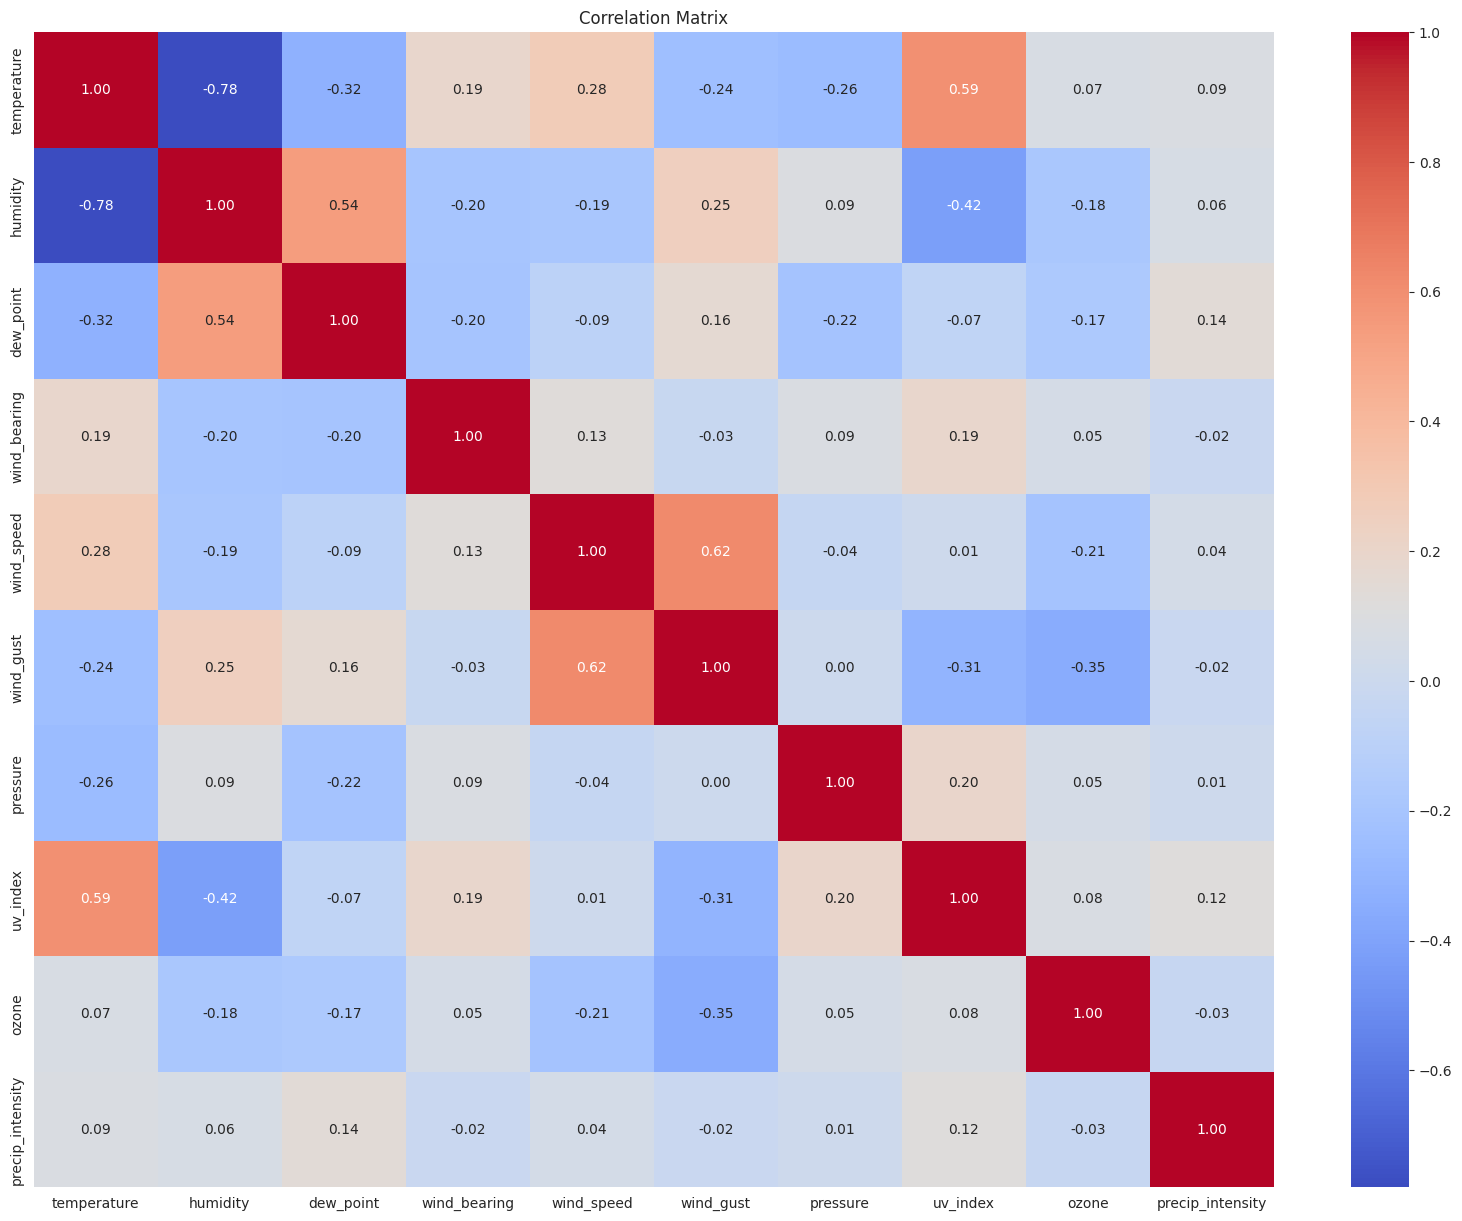

In [22]:
df_weather_cleaned = df_weather.dropna()
    
result = SparkCorrelationAnalyzer.analyze_correlation(df_weather_cleaned, feature_cols=numeric_columns)

# Extract the correlation matrix from the result
correlation_matrix = pd.DataFrame(result["correlation_matrix"], columns=result["feature_columns"], index=result["feature_columns"])

SparkVisualization.visualize_correlation_matrix(correlation_matrix)


24/03/21 10:32:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


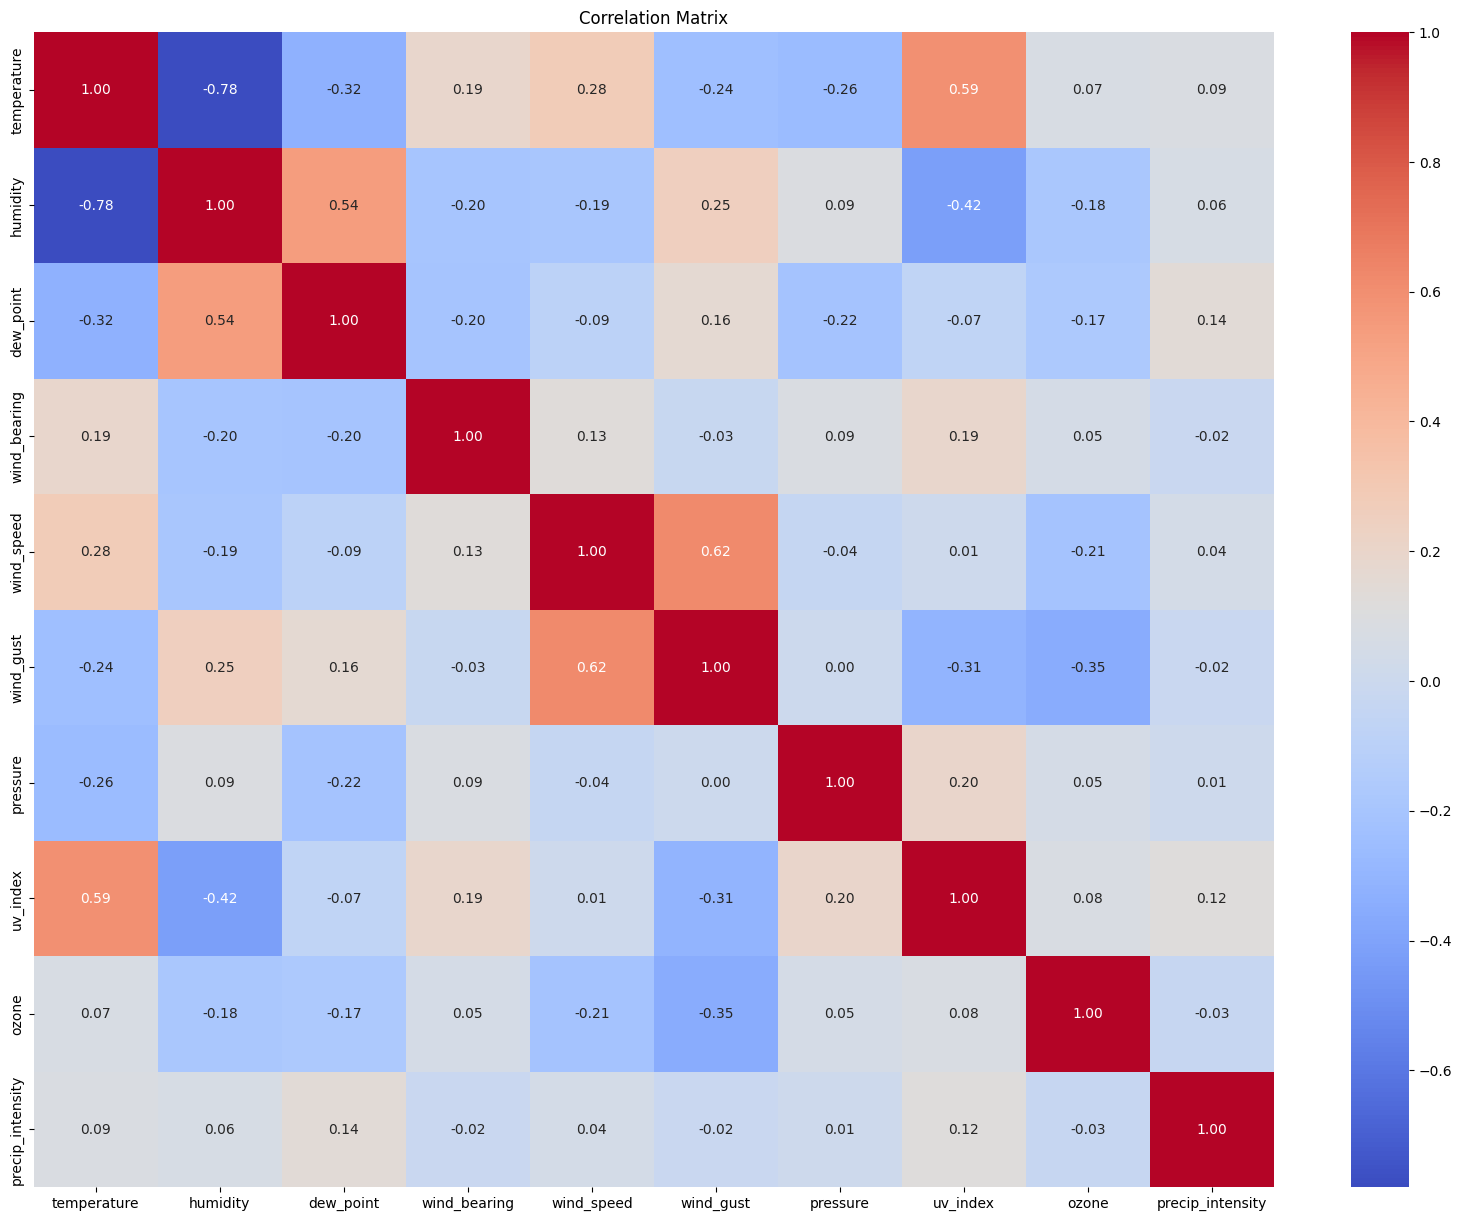

In [12]:
df_weather_cleaned = df_weather.dropna()

SparkCorrelationAnalyzer.analyze_correlation(df_weather_cleaned, feature_cols=numeric_columns)


### PoC2

In [24]:
from pyspark.ml.feature import StringIndexer

# StringIndexer 
indexer = StringIndexer(inputCol="icon", outputCol="icon_Indexed")
weather_indexed_df = indexer.fit(df_weather_cleaned).transform(df_weather_cleaned)
 
weather_indexed_df.show()

+----------------+-----------+--------+---------+------------+----------+---------+--------+--------+-----+----------------+-------------------+------------+
|  datetime_local|temperature|humidity|dew_point|wind_bearing|wind_speed|wind_gust|pressure|uv_index|ozone|precip_intensity|               icon|icon_Indexed|
+----------------+-----------+--------+---------+------------+----------+---------+--------+--------+-----+----------------+-------------------+------------+
|01-10-2019 00:00|         26|       1|    22.01|         101|      3.08|     6.42| 1008.45|       0|268.6|             0.0|partly-cloudy-night|         3.0|
|01-10-2019 01:00|         25|       1|    22.06|         105|      2.94|     6.28| 1008.24|       0|269.1|             0.0|partly-cloudy-night|         3.0|
|01-10-2019 02:00|         25|       1|    22.06|         106|      2.82|     6.08|  1007.9|       0|269.7|             0.0|partly-cloudy-night|         3.0|
|01-10-2019 03:00|         24|       1|    21.87|   

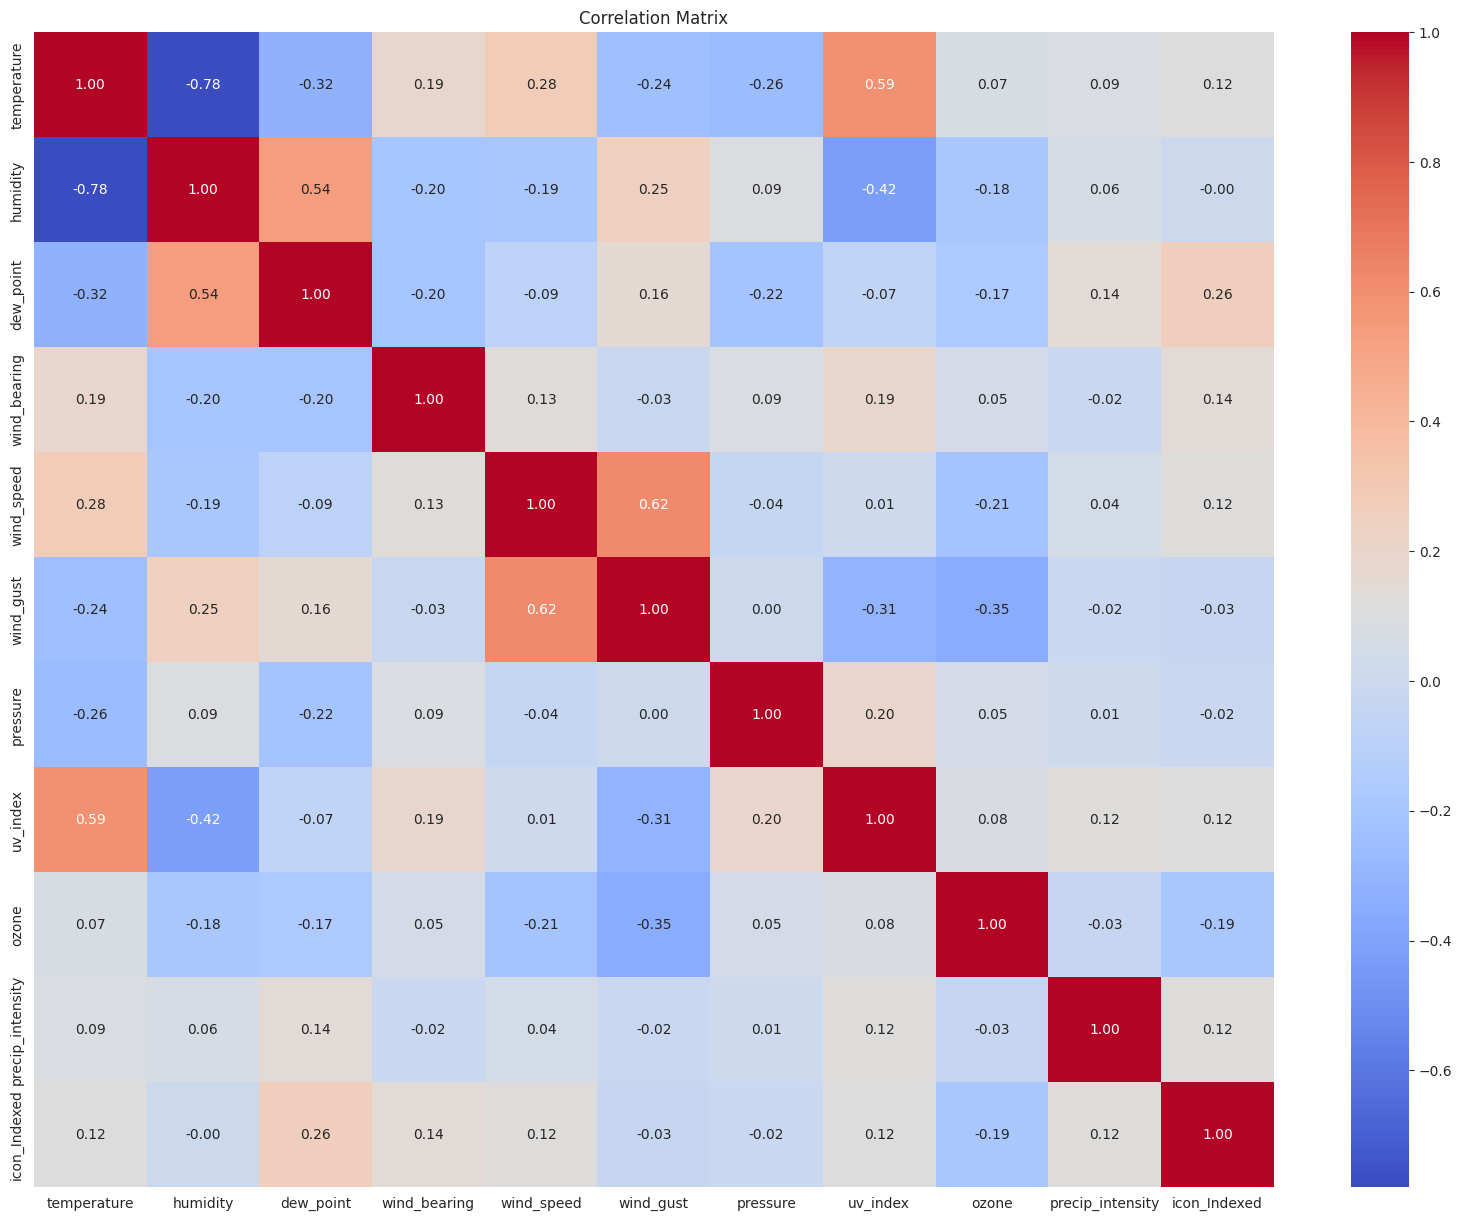

In [25]:
# LABEL ile de cprr matrix
weather_numeric_columns = [col_name for col_name, col_type in weather_indexed_df.dtypes if isinstance(weather_indexed_df.schema[col_name].dataType, NumericType)]

result4 = SparkCorrelationAnalyzer.analyze_correlation(weather_indexed_df, feature_cols=weather_numeric_columns)

# Extract the correlation matrix from the result
correlation_matrix4 = pd.DataFrame(result4["correlation_matrix"], columns=result4["feature_columns"], index=result4["feature_columns"])

SparkVisualization.visualize_correlation_matrix(correlation_matrix4)


### PoC3

In [26]:
from pyspark.sql.types import NumericType

df_churn_cleaned = df_churn.dropna()

churn_numeric_columns = [col_name for col_name, col_type in df_churn_cleaned.dtypes if isinstance(df_churn_cleaned.schema[col_name].dataType, NumericType)]



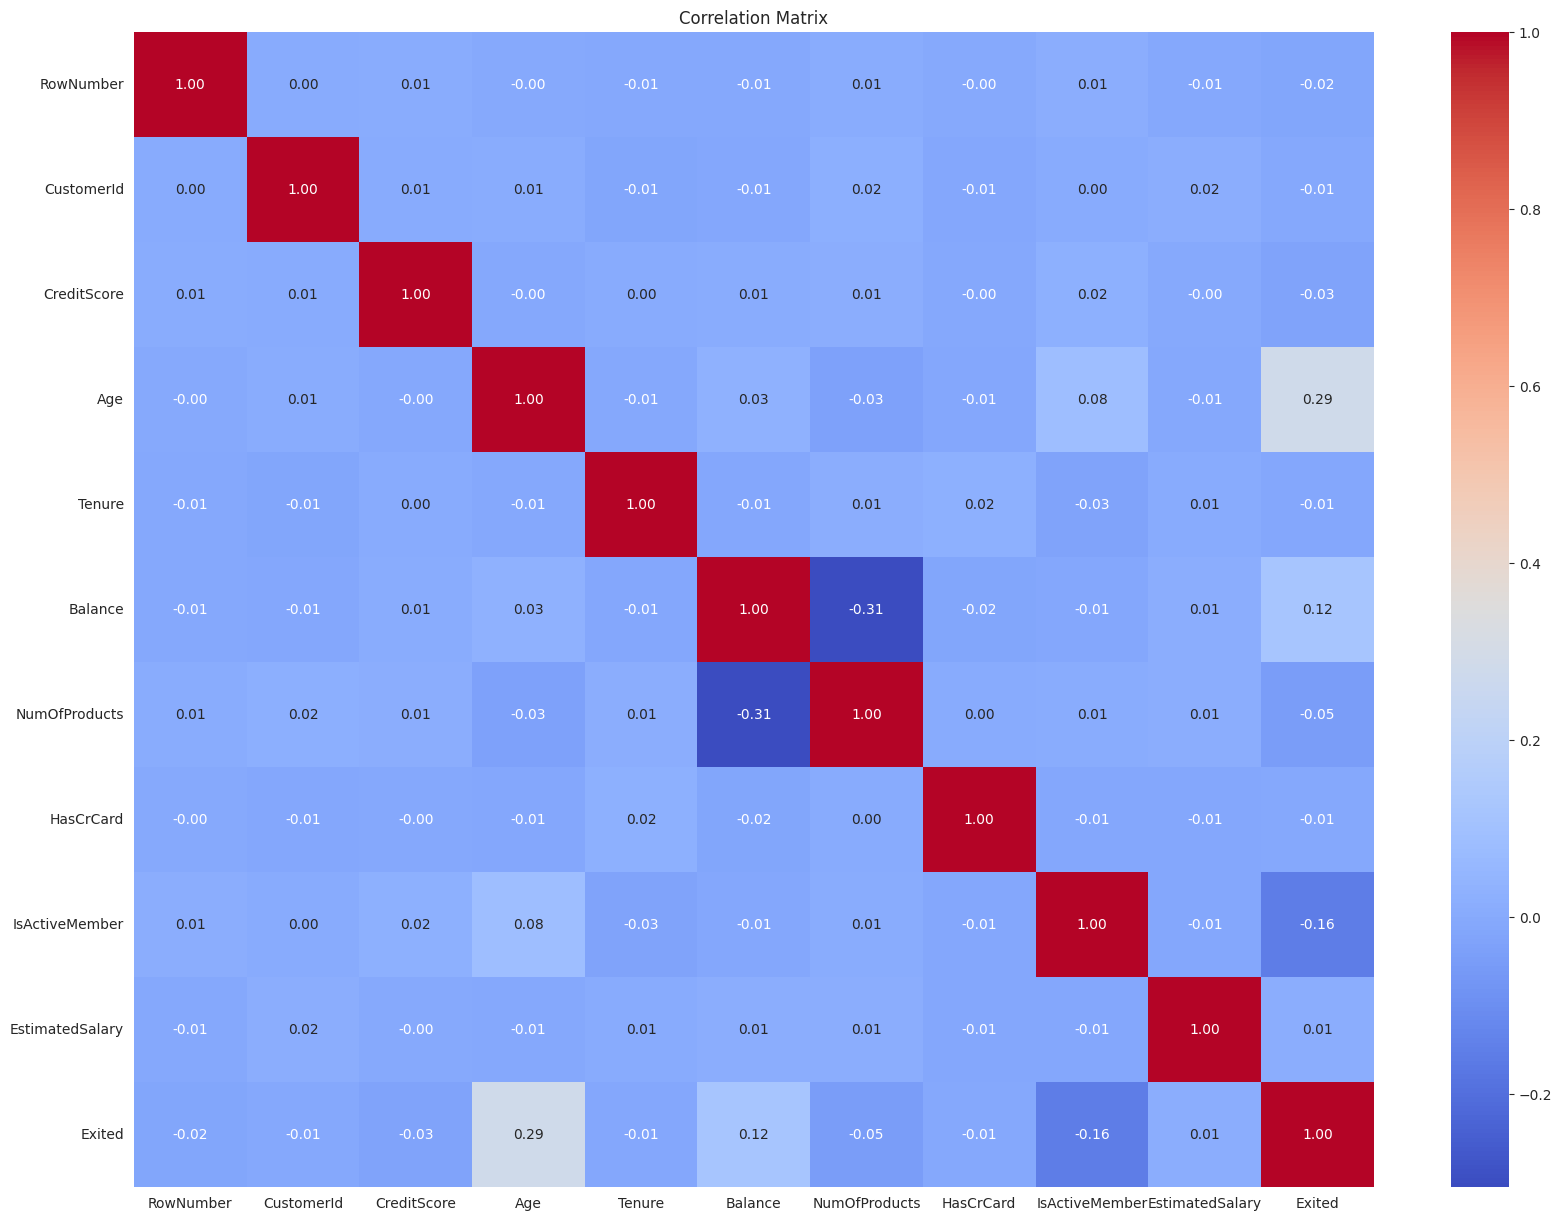

In [27]:
result3 = SparkCorrelationAnalyzer.analyze_correlation(df_churn_cleaned, feature_cols=churn_numeric_columns)

# Extract the correlation matrix from the result
correlation_matrix3 = pd.DataFrame(result3["correlation_matrix"], columns=result3["feature_columns"], index=result3["feature_columns"])

SparkVisualization.visualize_correlation_matrix(correlation_matrix3)